# Read an AOI

We are still standardizing the metadata. This data can be viewed (on a map) directly on github.

In [1]:
import geopandas as gpd

df_aoi = gpd.read_file('aois/Aleutians_pathNumber95.geojson')
df_aoi

,aoi_name,path_number,min_days_backward,month_range_lower,month_range_upper,num_neighbors_ref,geometry
0,Aleutians,95,364,6,10,3,"POLYGON Z ((-169.81786 54.53305 0.00000, -165...."
1,Aleutians,95,0,6,10,3,"POLYGON Z ((-169.81786 54.53305 0.00000, -165...."


<AxesSubplot:>

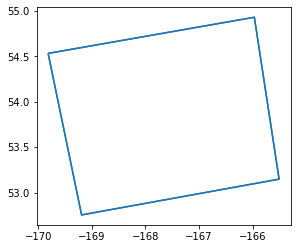

In [2]:
df_aoi.exterior.plot()

# Enumeration of GUNWs

Want to enumerate June - October 2021. There are a lot of ways to proceed. For example, for every month, do we want at the month previously? Or do we want to get the earliest dates from the previous year within June - October?

The specifics will have to be hashed out.

## Formatting Entries

Geojson only accepts certain types (lists are not permissible metadata entries). So we have to do some small (re-)formatting.

In [3]:
df_aoi = gpd.read_file('aois/Aleutians_pathNumber95.geojson')

# Format path numbers to list; requires list for inputs into enumerator
df_aoi['path_numbers'] = df_aoi['path_number'].map(lambda x: [x])

# Format months into list
df_aoi['months'] = df_aoi.agg(lambda row: list(range(row['month_range_lower'],
                                                     row['month_range_upper'] + 1)), axis=1)

# Drop redundent columns
df_aoi.drop(columns=['path_number', 
                     'month_range_lower', 
                     'month_range_upper'], inplace=True)

In [4]:
enum_records = df_aoi.to_dict('records')
enum_records

[{'aoi_name': 'Aleutians',
  'min_days_backward': 364,
  'num_neighbors_ref': 3,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7ff1a86d0f40>,
  'path_numbers': [95],
  'months': [6, 7, 8, 9, 10]},
 {'aoi_name': 'Aleutians',
  'min_days_backward': 0,
  'num_neighbors_ref': 3,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7ff1a86d0d00>,
  'path_numbers': [95],
  'months': [6, 7, 8, 9, 10]}]

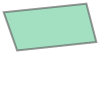

In [5]:
df_aoi.geometry.tolist()[0]

## Enumeration using `s1-enumerator`

In [6]:
from s1_enumerator import distill_all_pairs, enumerate_ifgs
import datetime

K = 0
enum_record = enum_records[0]

ifg_pairs_tiles = enumerate_ifgs(enum_record['geometry'],
                                 min_reference_date=datetime.datetime(2021, 6, 1),
                                 enumeration_type='tile',
                                 min_days_backward = 364,
                                 num_neighbors_ref=10,
                                 num_neighbors_sec=1,
                                 temporal_window_days=364,
                                 min_ref_tile_overlap_perc=.1,
                                 min_tile_aoi_overlap_km2=1e3,
                                 minimum_path_intersection_km2=1e3,
                                 minimum_ifg_area_km2=3e4,
                                 path_numbers=enum_record['path_numbers'],
                                 months=enum_record['months'],
                                 entire_s1_catalog=False)
# Distill for Generating IFGs
df_pairs = distill_all_pairs(ifg_pairs_tiles)

In [7]:
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,hash_id,geometry
0,[S1B_IW_SLC__1SDV_20210806T045607_20210806T045...,[S1B_IW_SLC__1SDV_20191028T045557_20191028T045...,2021-08-06,2019-10-28,95,06a49da00c4bd84bcc861bef44e5b3c9,"POLYGON ((-169.08434 52.42353, -169.08434 52.4..."
1,[S1B_IW_SLC__1SDV_20210818T045607_20210818T045...,[S1B_IW_SLC__1SDV_20191028T045557_20191028T045...,2021-08-18,2019-10-28,95,dc433fbe633e337ae18af1fbae0ebdf3,"POLYGON ((-165.88252 54.60118, -165.88252 54.6..."
2,[S1B_IW_SLC__1SDV_20210830T045608_20210830T045...,[S1B_IW_SLC__1SDV_20191028T045557_20191028T045...,2021-08-30,2019-10-28,95,14ede142e760c34949ddc19e8c667a59,"POLYGON ((-165.88442 54.60102, -165.88442 54.6..."
3,[S1B_IW_SLC__1SDV_20210911T045609_20210911T045...,[S1B_IW_SLC__1SDV_20191028T045557_20191028T045...,2021-09-11,2019-10-28,95,73a39ddc03374d8cc2350e47b542c826,"POLYGON ((-165.88242 54.60075, -165.88242 54.6..."
4,[S1B_IW_SLC__1SDV_20210923T045609_20210923T045...,[S1B_IW_SLC__1SDV_20191028T045557_20191028T045...,2021-09-23,2019-10-28,95,fdb0b98e67d2965d75d8742c8fca3f17,"POLYGON ((-165.88196 54.60150, -165.88196 54.6..."


<AxesSubplot:>

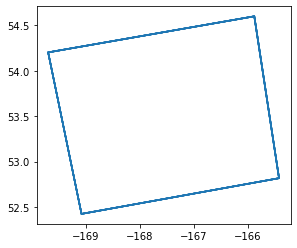

In [8]:
df_pairs.exterior.plot()

## Checking ASF DAAC for existing GUNWs (De-Duplication)

In [9]:
from s1_enumerator import duplicate_gunw_found
import concurrent
from tqdm import tqdm

n = df_pairs.shape[0]
with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    results = list(tqdm(executor.map(duplicate_gunw_found, df_pairs.to_dict('records')), total=n))

  0%|          | 0/8 [00:00<?, ?it/s]/Users/cmarshak/bekaert-team/s1-enumerator/s1_enumerator/formatter.py:19: UserWarning: Dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
100%|██████████| 8/8 [00:02<00:00,  3.68it/s]


In [10]:
df_pairs['existing_gunw'] = [r != '' for r in results]
df_pairs['existing_gunw_id'] = results
total_existing_gunws = df_pairs['existing_gunw'].sum()
print('existing_gunws: ', total_existing_gunws)
print('Total pairs', df_pairs.shape[0])

existing_gunws:  0
Total pairs 8


## Filter existing GUNWs and Duplicate Pairs

The latter in case we "over" enumerate doing some `for` loop in the enumeration steps.

In [11]:
df_pairs_filtered = df_pairs[~df_pairs['existing_gunw']].reset_index(drop=True)
df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
print('after filtering, total pairs: ', df_pairs_filtered.shape[0])

after filtering, total pairs:  8


In [12]:
records_to_submit = df_pairs_filtered.to_dict('records')
records_to_submit[0]

{'reference': ['S1B_IW_SLC__1SDV_20210806T045607_20210806T045637_028121_035ACC_BBE0'],
 'secondary': ['S1B_IW_SLC__1SDV_20191028T045557_20191028T045627_018671_0232FE_1587'],
 'reference_date': '2021-08-06',
 'secondary_date': '2019-10-28',
 'path_number': 95,
 'hash_id': '06a49da00c4bd84bcc861bef44e5b3c9',
 'geometry': <shapely.geometry.polygon.Polygon at 0x7ff1d887b1c0>,
 'existing_gunw': False,
 'existing_gunw_id': ''}

# Submit jobs to Hyp3

In [13]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-isce.asf.alaska.edu/')

job_dicts = [{'name': 'test-aleutian-95',
              'job_type': 'INSAR_ISCE_TEST',
              'job_parameters': {'granules': r['reference'],
                                 'secondary_granules': r['secondary']}} 
             for r in records_to_submit[2:3]]


# UNCOMMENT TO SUBMIT
#jobs = hyp3_isce.submit_prepared_jobs(job_dicts)

In [14]:
jobs = hyp3_isce.find_jobs()
len(jobs)

3

In [15]:
jobs

Batch([Job.from_dict({'job_id': 'c3a0a4e3-164e-4873-ba79-6b7383326ed0', 'job_type': 'INSAR_ISCE_TEST', 'request_time': '2021-12-02T23:34:51+00:00', 'status_code': 'RUNNING', 'user_id': 'cmarshak', 'name': 'test-aleutian-95', 'job_parameters': {'granules': ['S1B_IW_SLC__1SDV_20210830T045608_20210830T045638_028471_0365BF_4C6A'], 'secondary_granules': ['S1B_IW_SLC__1SDV_20191028T045557_20191028T045627_018671_0232FE_1587']}}), Job.from_dict({'job_id': '62e762ff-1ce3-40c2-a7a4-99ef2bdc0c18', 'job_type': 'INSAR_ISCE_TEST', 'request_time': '2021-12-02T23:31:19+00:00', 'status_code': 'RUNNING', 'user_id': 'cmarshak', 'name': 'test-aleutian-95', 'job_parameters': {'granules': ['S1B_IW_SLC__1SDV_20210818T045607_20210818T045637_028296_036045_AE35'], 'secondary_granules': ['S1B_IW_SLC__1SDV_20191028T045557_20191028T045627_018671_0232FE_1587']}}), Job.from_dict({'job_id': '0b68c579-c4ea-42f4-bdf0-2baf6be01522', 'job_type': 'INSAR_ISCE_TEST', 'request_time': '2021-12-02T22:18:17+00:00', 'status_code

In [16]:
# jobs = hyp3_isce.watch(jobs)